<h1>HVAC Analysis of Ball Arena</h1>
This notebook looks into the requirements for real time opearion of HVAC systems in Ball Arena (Denver, Co.), as well as some demonstration metrics.

<h2>Setup</h2>
Load dependencies for project:

In [162]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import psychrolib
import pyromat as pm
import ht 
from pyfluids import Fluid, FluidsList, Input
import math
import numpy as np
import pandas as pd

<h2>Define Useful Functions</h2>
These funcitons include converting °F to °C, °C to K, and converting between m and ft.

In [163]:
def getCelciusFromFahrenheit(tf):
    return (tf - 32) / 1.8

def getSquMeterFromSquFt(squFt):
    return squFt * 0.092903

def celciusToKelvin(cel):
    return cel + 273.15

def getMeterFromFeet(feet):
    return feet * 0.3048

<h2> Define Psychrometric Functions </h2>
These functions will be used throughout the code to get psychromtric data pertienent to modeling HVAC systems.

In [164]:
#For retriving water and air variables 
h2o = pm.get("ig.H2O")
air = pm.get("ig.air")

# For calculating P_sat given temperature| temperature in K, out in kPa
def getPsat(temperature):
    return h2o.p(T=temperature)

# For determining current water pressure given temperature in K, relativeHumidity in %, out in kPa
def getWaterPressure(temperature, relativeHumidity):
    return relativeHumidity / 100 * getPsat(temperature)

#Define R value for air [IG model]
Ra = 8.314

# for getting mass flow rate of water| temperature in K, relativeHumidity in %, volumeFlow in m^3/s, out in kg/s 
def getWaterMass(temperature, relativeHumidity, volumeFlow):
    return getWaterPressure(temperature, relativeHumidity) * volumeFlow * h2o.mw() / Ra / temperature

# for getting mass flow rate| temperature in K, dryAirPressure in kPa, volumeFlow in m^3/s, out in kg/s 
def getDryAirMass(temperature, dryAirPressure, volumeFlow):
    return dryAirPressure * volumeFlow * h2o.mw() / Ra / temperature

# Used for getting the dry air pressure| pressure in kPa, waterPressure in kPa, out in kPa
def getDryAirPressure(pressure, waterPressure):
    return pressure - waterPressure

# Used for getting the specific humidity| pressure in kPa, waterPressure in kPa, out in 0 to 1
def getSpecificHumidity(pressure, waterPressure):
    return 0.622 * waterPressure / (pressure - waterPressure)


# For getting water enthalpy| temperature in K, pressure in kPa, out in kJ/kmol
def getWaterEnthalpy(temperature, pressure):
    return h2o.h(T=temperature, p=pressure)

# For getting dry air enthalpy| temperature in K, pressure in kPa, out in kJ/kmol
def getDryAirEnthalpy(temperature, pressure):
    return air.h(T=temperature, p=pressure)
    
# For getting water enthalpy flow| temperature in K, pressure in kPa, massFlow in kg/s, out in kJ/s
def getWaterEnthalpyFlow(temperature, pressure, massFlow):
    return getWaterEnthalpy(temperature, pressure) / h2o.mw() * massFlow

# For getting dry air enthalpy flow| temperature in K, pressure in kPa, massFlow in kg/s, out in kJ/s
def getDryAirEnthalpyFlow(temperature, pressure, massFlow):
    return getDryAirEnthalpy(temperature, pressure) / air.mw() * massFlow
    
# For determining required refrigerant| qout in kW, out in tons of refrigerant
def getRequiredRefrigerant(qout):
    return .2893 * qout

def getDryAirMassFlowRate(pressure, vaporpressure, volumeflowrate, temperature):
    return volumeflowrate / (air.v(T=temperature) + getSpecificHumidity(pressure, vaporpressure) * h2o.v(T=temperature))

def getVaporMassFlowRate(pressure, vaporpressure, volumeflowrate, temperature):
    humidity = getSpecificHumidity(pressure, vaporpressure)
    if(humidity is None or humidity == 0):
        return 0
    return volumeflowrate / (air.v(T=temperature) / humidity + h2o.v(T=temperature))

<h2> Game Conditions </h2>
Standard game conditions as per NHL requirements and average game length

In [165]:
# Values related to the game
gameLength = 3 # hours

# Desired conditions to be mainted throughout the game
desiredHumidity = 35 # %
desiredTemperature = getCelciusFromFahrenheit(63) # C
airPressure = 84.0 # Kpa

<h2> Define Arena Variables </h2>
Data related to the arena, attendees, and game requirements

In [166]:
# Stadium size information
stadiumFloorArea = getSquMeterFromSquFt(675000) # m^2
stadiumSizeRatio = 85/200
stadiumLength = math.sqrt(stadiumFloorArea / (1 + stadiumSizeRatio)) # m
stadiumWidth = stadiumFloorArea / stadiumLength # m
arenaWidth = getMeterFromFeet(85 * 10 / 1.5)
arenaLength = getMeterFromFeet(200 * 12.5 / 2.5)
stadiumHeight = 15 # m (Guess for now cant find any actual data)

print("Stadium Floor Area: " + str(stadiumFloorArea) + "m^2 , Stadium Length: " + str(stadiumLength) + "m , Stadium Width: " + str(stadiumWidth) + "m")

# Values related to the people
amountPeople = 18000 # Persons
surfaceAreaPerson = 1.8 # m^2
heatGenerationPerson = 58.2 # W/m^2
waterBreathGenerationPerson = 16.7 / 3600# g/s
waterSweatGenerationPerson = 3.5 * 1000 / 3600 # g/s
playerHeatGeneration = 1000 # W/m^2
numberPlayers = 6 * 12

#Energy Cost
energyCost = 0.154 # $ / kW-h

# EFfficiency
COP = 3.517/1.36
overallInefficiency = 75 # %

Stadium Floor Area: 62709.525m^2 , Stadium Length: 209.77770189065927m , Stadium Width: 298.9332251941895m


<h2> HVAC Variables </h2>
Flow rate of HVAC system 

In [167]:
# HVAC information
hvacVolumeFlowRate = 724000 / 60 * 0.03# m^3 / s
print("Air Flow: " + str(hvacVolumeFlowRate) + "m^3/s")

Air Flow: 361.99999999999994m^3/s


<h2>Ice Rink Variables</h2>
These values will say consistent throughout the modeling process

In [168]:
# Ice rink related values
rinkArea = getSquMeterFromSquFt(19000) # m^2
rinkLength = getMeterFromFeet(200) # m
rinkIceTemperature = getCelciusFromFahrenheit(22) # C
rinkAirSpeedAdjustment = 10
rinkAirSpeed = hvacVolumeFlowRate / (arenaWidth * stadiumHeight) * rinkAirSpeedAdjustment
print("Air Speed: " + str(rinkAirSpeed) + "m/s")

# Related to determining the heat loss through the ice
filmTemperature = (desiredTemperature + rinkIceTemperature) / 2 

# To get air fluid properties at film temp
airFluid = Fluid(FluidsList.Air).with_state(Input.temperature(filmTemperature), Input.pressure(airPressure * 1000))
airDensity = airFluid.density # kg/m^3
airThermalConduction = airFluid.conductivity
airKinematicViscosity = airFluid.kinematic_viscosity # Std
airReynoldsNumber = rinkAirSpeed * rinkLength / airKinematicViscosity
airPrandtlNumber = airFluid.prandtl
rinkNu = ht.conv_external.Nu_external_horizontal_plate(airReynoldsNumber, airPrandtlNumber)
rinkConvectionCoe = rinkNu * airThermalConduction / rinkLength
print("Ice Convection Coefficient: " + str(rinkConvectionCoe))

# Goal of section
rinkConvection = rinkArea * rinkConvectionCoe * (desiredTemperature - rinkIceTemperature) / 1000 # kW
print("Rink Heat Loss: " + str(rinkConvection) + " kW")

Air Speed: 1.397251814111471m/s
Ice Convection Coefficient: 2.780199330148111
Rink Heat Loss: 111.7816781495868 kW


<h2> Testing Variables </h2>
The primary testing variables for this expriment include the air temperature and humidity, with the aim to study when the refrigeration costs are most expensive

In [169]:
weatherData = pd.read_csv(r'./Denver_2022-2023.csv')
tempData = weatherData["temp"] # °C
humidityData = weatherData["humidity"] # %

In [170]:
# Standard atmospheric conditions
airTemperature = tempData # C
airHumidity = humidityData # %

<h2> HVAC Analysis </h2>
Given the preceeding sections exploring defining functions and variables. We can preform an effective HVAC analysis on the operating costs.

In [171]:
def calcHVAC(airTemperature, airHumidity, amountPeople):
    # Related to hvac analysis
    mDotPeople = (waterBreathGenerationPerson * amountPeople + numberPlayers * waterSweatGenerationPerson) / 1000
    qDotPeople = surfaceAreaPerson * heatGenerationPerson * amountPeople/1000 + playerHeatGeneration * numberPlayers / 1000
    qDotIce = -rinkConvection
    #print("People Water Production: " + str(mDotPeople) + " kg/s")

    stateOneVaporPressure = getWaterPressure(celciusToKelvin(airTemperature), airHumidity / 100)
    stateOneAirPressure = getDryAirPressure(airPressure, stateOneVaporPressure)
    #print("State One, Vapor Pressure: " + str(stateOneVaporPressure) + " kPa")

    dryAirMassFlowRate = getDryAirMassFlowRate(airPressure, stateOneVaporPressure, hvacVolumeFlowRate, celciusToKelvin(airTemperature))
    stateOneVaporFlowRate = getVaporMassFlowRate(airPressure, stateOneVaporPressure, hvacVolumeFlowRate, celciusToKelvin(airTemperature))
    #print("Dry Air Flow Rate: " + str(dryAirMassFlowRate) + " kg/s, Vapor Flow Rate: " + str(stateOneVaporFlowRate) + " kg/s")

    stateTwoVaporPressure = getWaterPressure(celciusToKelvin(desiredTemperature), desiredHumidity / 100)
    stateTwoAirPressure = getDryAirPressure(airPressure, stateTwoVaporPressure)
    #print("State Two, Vapor Pressure: " + str(stateTwoVaporPressure) + " kPa")

    stateTwoVaporFlowRate = getVaporMassFlowRate(airPressure, stateTwoVaporPressure, hvacVolumeFlowRate, celciusToKelvin(desiredTemperature))
    #print("State Two Vapor Flow Rate: " + str(stateOneVaporFlowRate) + " kg/s")

    mDotAdditive = stateTwoVaporFlowRate - stateOneVaporFlowRate - mDotPeople
    #print("Water Adjustment Needed: " + str(mDotAdditive) + " kg/s")

    inletEnthalpyDot = getWaterEnthalpyFlow(celciusToKelvin(airTemperature), airPressure, stateOneVaporFlowRate) + getWaterEnthalpyFlow(celciusToKelvin(desiredTemperature), airPressure, mDotPeople) + getWaterEnthalpyFlow(300, airPressure, mDotAdditive) + getDryAirEnthalpyFlow(celciusToKelvin(airTemperature), airPressure, dryAirMassFlowRate)
    outletEnthalpyDot = getWaterEnthalpyFlow(celciusToKelvin(desiredTemperature), airPressure, stateTwoVaporFlowRate) + getDryAirEnthalpyFlow(celciusToKelvin(desiredTemperature), airPressure, dryAirMassFlowRate)

    qNetDotCooling = outletEnthalpyDot - inletEnthalpyDot - qDotPeople + qDotIce
    qNetDotCoolingInefficient = qNetDotCooling * (100 / overallInefficiency)
    qNetDot = abs(qNetDotCoolingInefficient) / COP
    qNet = abs(qNetDot) * gameLength * 3600

    totalCost = abs(qNetDot) * gameLength * energyCost 

    #print("Energy Required For A Game: " + str(qNet) + " kJ, " + str(qNetDot) + " kW, with total cost of " + str(totalCost) + "$")

    return qNetDot, qNetDotCoolingInefficient, totalCost

In [172]:
energyArray = []
energyCoolingArray = []
costArray = []

for i in range(weatherData["datetime"].size):
    airTemperature = tempData[i]
    airHumidity = tempData[i]

    qNetDot, qNetDotCooling, totalCost = calcHVAC(airTemperature, airHumidity, amountPeople)

    #Add data for date to energy array 
    energyArray.append(qNetDot)
    costArray.append(totalCost)
    energyCoolingArray.append(abs(qNetDotCooling))

<h2>Plot the Data</h2>

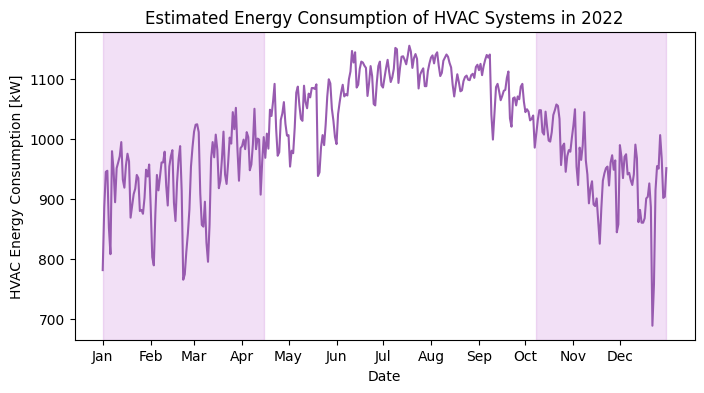

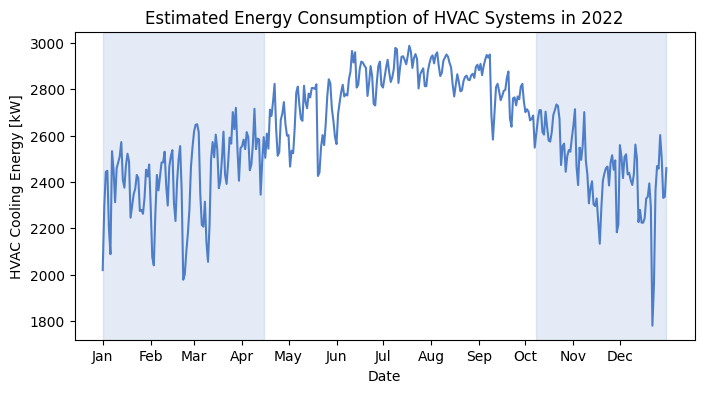

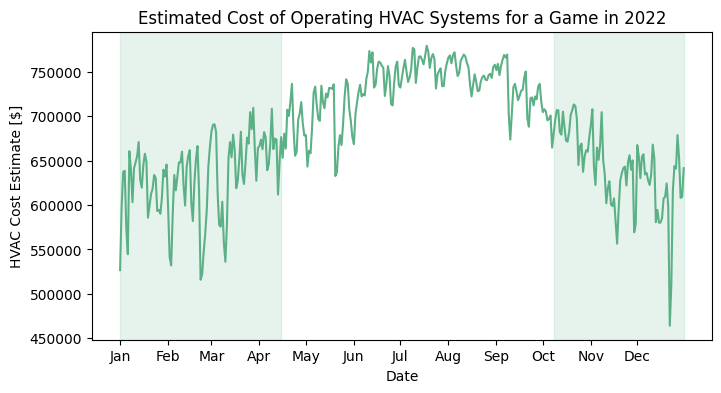

In [173]:
#Plot Enegy Data
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(weatherData["datetime"], energyArray, color='#985bb0')
ax.set_xlabel('Date')
ax.set_ylabel('HVAC Energy Consumption [kW]')
ax.set_title("Estimated Energy Consumption of HVAC Systems in 2022")

# Set xticks to show one tick per month without the year
months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

# Set xticks explicitly to exclude the last tick
xticks = ax.get_xticks()[:-1]
ax.set_xticks(xticks)

# Highlight dates between Jan 1 and Apr 15, and Oct 7 to Dec 31
ax.axvspan(weatherData["datetime"][0], weatherData["datetime"][104], alpha=0.15, color='#a92fc4')
ax.axvspan(weatherData["datetime"][280], weatherData["datetime"].iloc[-1], alpha=0.15, color='#a92fc4')

plt.show()

#Plot Cooling Enegy Data
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(weatherData["datetime"], energyCoolingArray, color='#4f7ec9')
ax.set_xlabel('Date')
ax.set_ylabel('HVAC Cooling Energy [kW]')
ax.set_title("Estimated Energy Consumption of HVAC Systems in 2022")

# Set xticks to show one tick per month without the year
months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

# Set xticks explicitly to exclude the last tick
xticks = ax.get_xticks()[:-1]
ax.set_xticks(xticks)

# Highlight dates between Jan 1 and Apr 15, and Oct 7 to Dec 31
ax.axvspan(weatherData["datetime"][0], weatherData["datetime"][104], alpha=0.15, color='#4f7ec9')
ax.axvspan(weatherData["datetime"][280], weatherData["datetime"].iloc[-1], alpha=0.15, color='#4f7ec9')

plt.show()


#Plot Cost Data
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(weatherData["datetime"], costArray, color='#5bb086')
ax.set_xlabel('Date')
ax.set_ylabel('HVAC Cost Estimate [$]')
ax.set_title("Estimated Cost of Operating HVAC Systems for a Game in 2022")

# Set xticks to show one tick per month without the year
months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

# Set xticks explicitly to exclude the last tick
xticks = ax.get_xticks()[:-1]
ax.set_xticks(xticks)

# Highlight dates between Jan 1 and Apr 15, and Oct 7 to Dec 31
ax.axvspan(weatherData["datetime"][0], weatherData["datetime"][104], alpha=0.15, color='#5bb086')
ax.axvspan(weatherData["datetime"][280], weatherData["datetime"].iloc[-1], alpha=0.15, color='#5bb086')
plt.show()

<h2>Further Exploration</h2>
Exploring the impact of stadium capacity on HVAC load assuming average conditions during hockey season

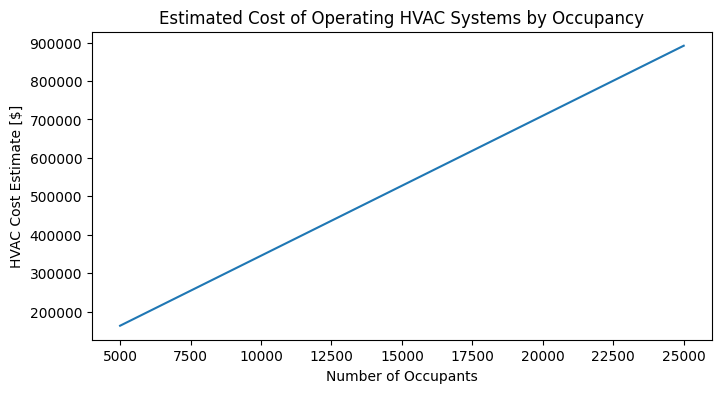

In [174]:
amountPeople = [5000, 10000, 15000, 20000, 25000] # Persons

energyArray = []
costArray = []
energyCoolingArray = []

#calculate average weather for hockey season
meanTemp = (tempData[0:104].mean() + tempData[280:364].mean()) / 2
meanHumidity = (humidityData[0:104].mean() + humidityData[280:364].mean()) / 2

for amount in amountPeople:
    qNetDot, qNetCooling, totalCost = calcHVAC(meanTemp, meanHumidity, amount)

    energyArray.append(qNetDot)
    costArray.append(totalCost)
    energyCoolingArray.append(qNetCooling)
    
#Plot Enegy Data
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(amountPeople, costArray)
ax.set_xlabel('Number of Occupants')
ax.set_ylabel('HVAC Cost Estimate [$]')
ax.set_title("Estimated Cost of Operating HVAC Systems by Occupancy")
plt.show()



Forecast of operational costs for hosting games

In [175]:
#get weather forecast
import urllib.request
import sys
import json

try: 
  ResultBytes = urllib.request.urlopen("https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/denver?unitGroup=metric&include=days&key=9G7YW3LPY42P65Q9NN8ZL4X93&contentType=json")
  
  # Parse the results as JSON
  jsonData = json.load(ResultBytes)
  weatherForecast = pd.json_normalize(jsonData["days"])
except urllib.error.HTTPError  as e:
  ErrorInfo= e.read().decode() 
  print('Error code: ', e.code, ErrorInfo)
  sys.exit()
except  urllib.error.URLError as e:
  ErrorInfo= e.read().decode() 
  print('Error code: ', e.code,ErrorInfo)
  sys.exit()





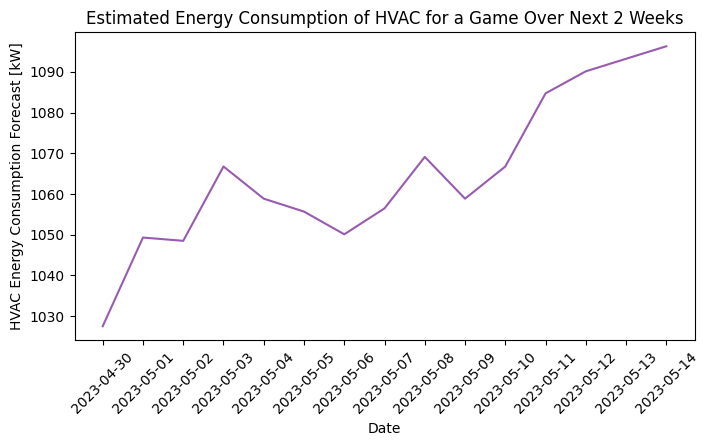

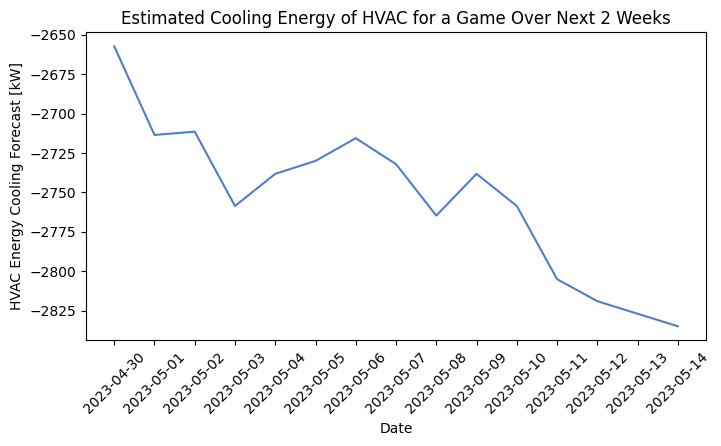

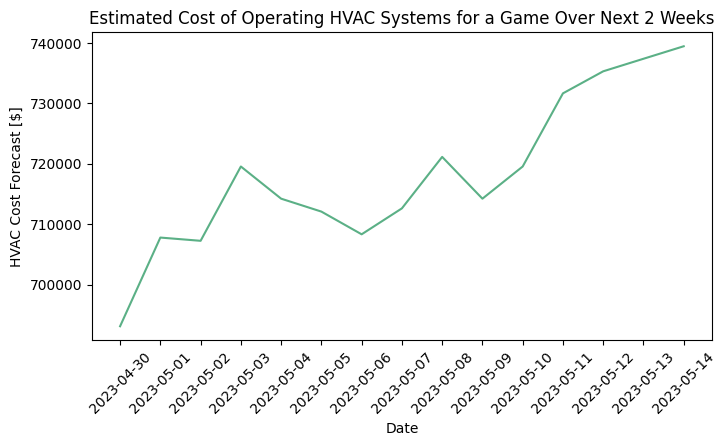

In [176]:
weatherForecast = pd.json_normalize(jsonData["days"])

#calculate predicted costs
tempData = weatherForecast["temp"] # °C
humidityData = weatherForecast["humidity"] # %

energyArray = []
energyCoolingArray = []
costArray = []
amountPeople = 18000

for i in range(weatherForecast["datetime"].size):
    airTemperature = tempData[i]
    airHumidity = tempData[i]

    qNetDot, qNetCooling, totalCost = calcHVAC(airTemperature, airHumidity, amountPeople)

    #Add data for date to energy array 
    energyArray.append(qNetDot)
    costArray.append(totalCost)
    energyCoolingArray.append(qNetCooling)



#Plot

#Plot Enegy Data
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(weatherForecast["datetime"], energyArray, color='#985bb0')
ax.set_xlabel('Date')
ax.set_ylabel('HVAC Energy Consumption Forecast [kW]')
ax.set_title("Estimated Energy Consumption of HVAC for a Game Over Next 2 Weeks")

# Set xticks to show dates
ax.tick_params(axis='x', labelrotation=45)

plt.show()

#Plot Cooling Enegy Data
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(weatherForecast["datetime"], energyCoolingArray, color='#4f7ec9')
ax.set_xlabel('Date')
ax.set_ylabel('HVAC Energy Cooling Forecast [kW]')
ax.set_title("Estimated Cooling Energy of HVAC for a Game Over Next 2 Weeks")

# Set xticks to show dates
ax.tick_params(axis='x', labelrotation=45)

plt.show()


#Plot Cost Data
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(weatherForecast["datetime"], costArray, color='#5bb086')
ax.set_xlabel('Date')
ax.set_ylabel('HVAC Cost Forecast [$]')
ax.set_title("Estimated Cost of Operating HVAC Systems for a Game Over Next 2 Weeks")

# Set xticks to show dates
ax.tick_params(axis='x', labelrotation=45)

plt.show()